# Example 4 Groups Comparison

This example performs an analysis tip data in the file `/data/tips.csv`. The data contains 244 tips and records the following features,

| Feature | Description | Unit|
|---------|-------------|------|
|`Total Bill` | Total cost of meal.| Dollars | 
| `Sex` | Male or Female.| (M, F) | 
| `Smoker` | Do the guests smoke.| (Yes, No) |
| `Day` | Day of week. | (Thu, Fri, Sat, Sun) |
| `Time` | Time of Day. | (Day, Night) |
| `Size` | Number of guests. | Count |

In this analysis the impact of the `Day` feature will be determined by comparing the tips for each day. Since there are four day variables the model distributions will be four dimensional.

## Model
 The likelihood distribution is assumed to be a Gamma Distribution,

$
\begin{align}
p(x \mid \alpha, \beta) = \frac{1}{\Gamma(\alpha)\beta^\alpha}x^{\alpha}e^{-x/\beta}
\end{align}
\tag{1}
$

Where,

$
\begin{align}
\Gamma(\alpha) = \int_0^\infty t^{\alpha - 1}e^{-t}
\end{align}
\tag{2}
$

Assume that the parameter priors are given by,

$
\begin{align}
\alpha &\sim \mathcal{HN}(\sigma_\alpha) \\
\beta &\sim \mathcal{HN}(\sigma_\beta)
\end{align}
\tag{3}
$


In [105]:
%reload_ext autoreload
%autoreload 2

# import system modules and set local import path
import os
import sys
import numpy
import pandas
from matplotlib import pyplot
from scipy import stats
import pymc
import arviz

sys.path.insert(0, os.path.abspath('../..'))

from lib import config
from lib.plots import (curve, comparison, scatter, ridge_plot)

pyplot.style.use(config.glyfish_style)

In [106]:
tips = pandas.read_csv('../../data/tips.csv', delimiter='\t')
tips.head()

,TotBill,Tip,Sex,Smoker,Day,Time,Size
0,18.29,3.76,M,Yes,Sat,Night,4
1,16.99,1.01,F,No,Sun,Night,2
2,10.34,1.66,M,No,Sun,Night,3
3,21.01,3.50,M,No,Sun,Night,3
4,23.68,3.31,M,No,Sun,Night,2


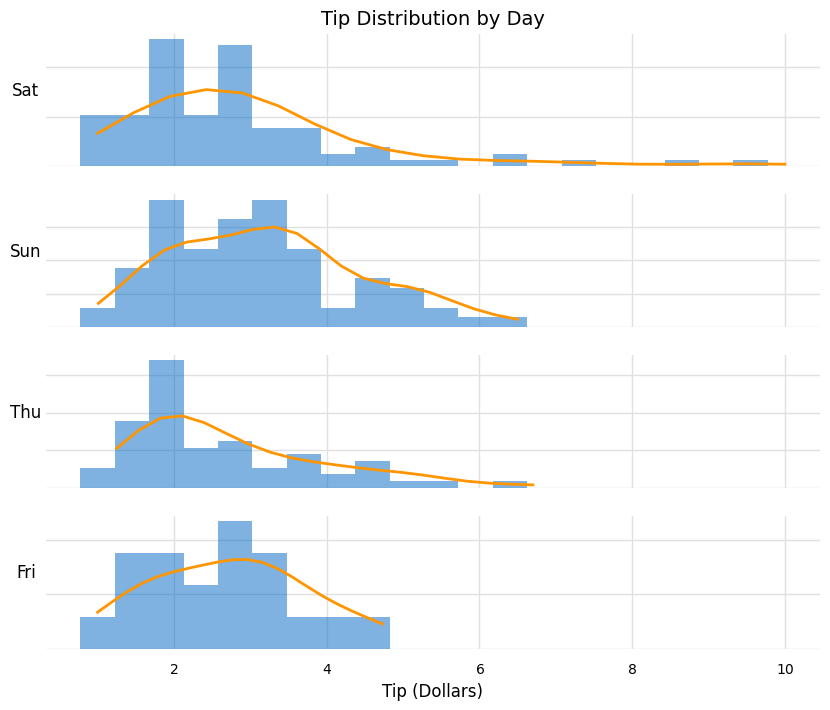

In [107]:
days = tips.Day.unique()
tips_by_day = [tips[tips.Day == day].Tip.values for day in days]

ridge_plot(days, tips_by_day, nbins=20, nkde=20, xlabel='Tip (Dollars)', title='Tip Distribution by Day')

In [108]:
def plot_gamma_pdf(idx):
    alpha_vals = [0.1, 0.5, 1.0, 2.0, 5.0, 7.0, 9.0, 11.0]
    beta_vals = [0.5, 1.0, 2.0]
    x_vals = numpy.linspace(0.01, 10, 100)
    title = f"Example of Gamma Distributions, $\\beta$ = {beta_vals[idx]}"
    pdfs = [numpy.array(stats.gamma.pdf(x_vals, a=alpha, scale=beta_vals[idx])) for alpha in alpha_vals]
    labels = [f'$\\alpha$ = {alpha}' for alpha in alpha_vals]
    comparison(pdfs, x_vals, title=title, labels=labels, xlabel='x', ylabel='PDF', ylim=(0, 0.5))

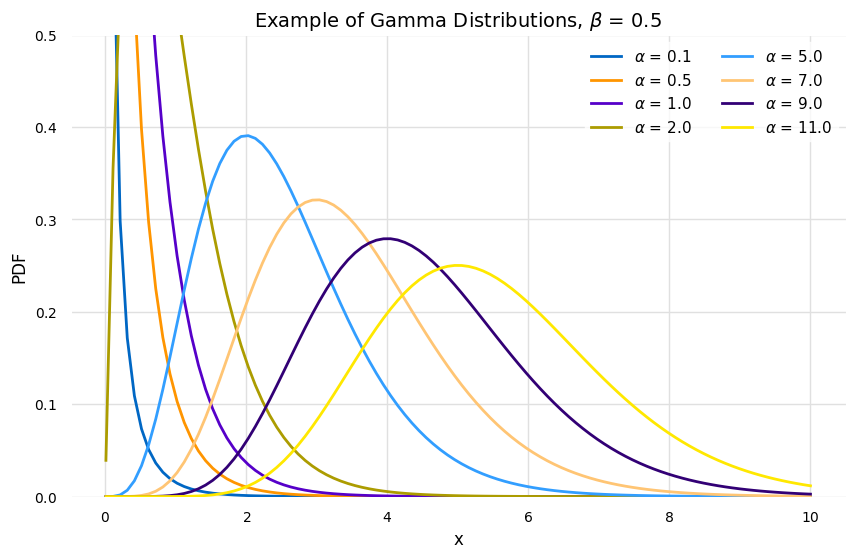

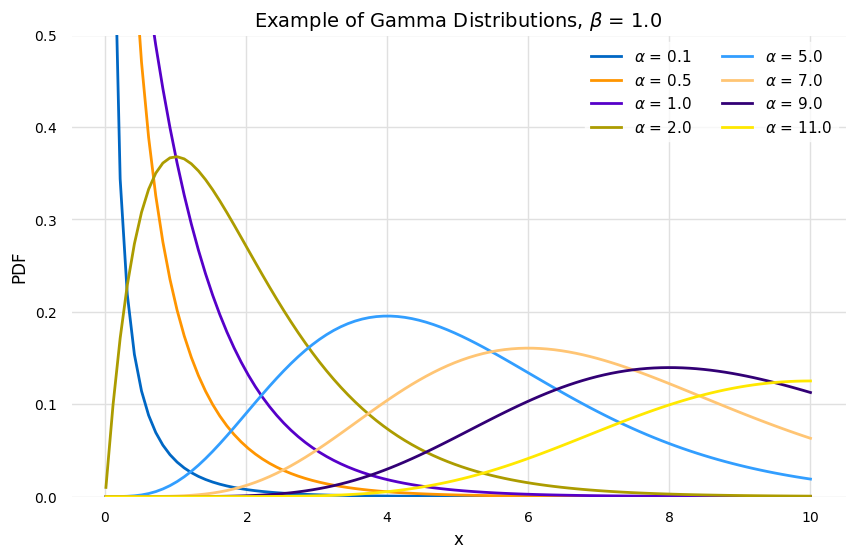

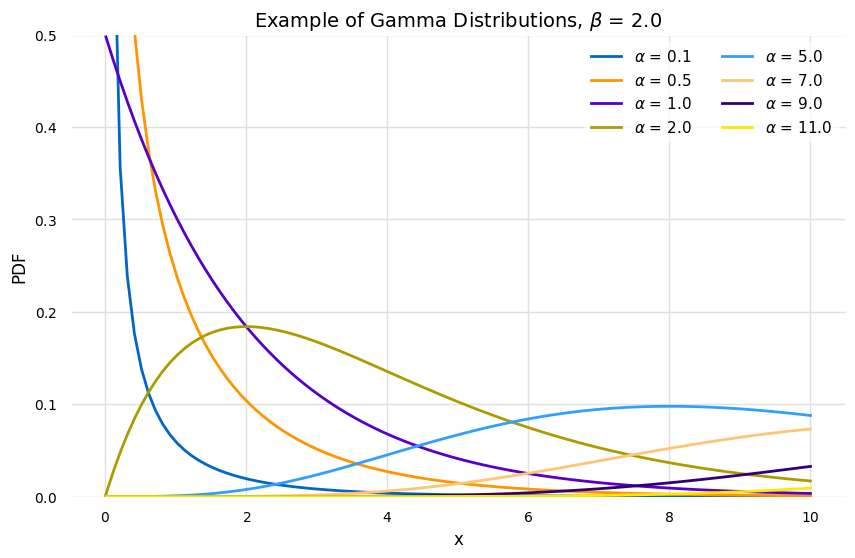

In [109]:
plot_gamma_pdf(0)
plot_gamma_pdf(1)
plot_gamma_pdf(2)

In [110]:
days = numpy.array(['Thu', 'Fri', 'Sat', 'Sun'])
tip_vals = tips.Tip.values
idx = pandas.Categorical(tips.Day, categories=days).codes
coords = {'Day': days, 'Obs': days[idx]}

In [111]:
mu_sigma = 10.0
sigma_sigma = 10.0
shape = 4

with pymc.Model(coords=coords) as model:
    μ = pymc.HalfNormal('μ', sigma=mu_sigma, shape=shape)
    σ = pymc.HalfNormal('σ', sigma=sigma_sigma, shape=shape)
    y = pymc.Gamma('Y', mu=μ[idx], sigma=σ[idx], observed=tip_vals, dims='Obs')
    
    idata = pymc.sample()
    idata.extend(pymc.sample_posterior_predictive(idata))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [Y]


Output()

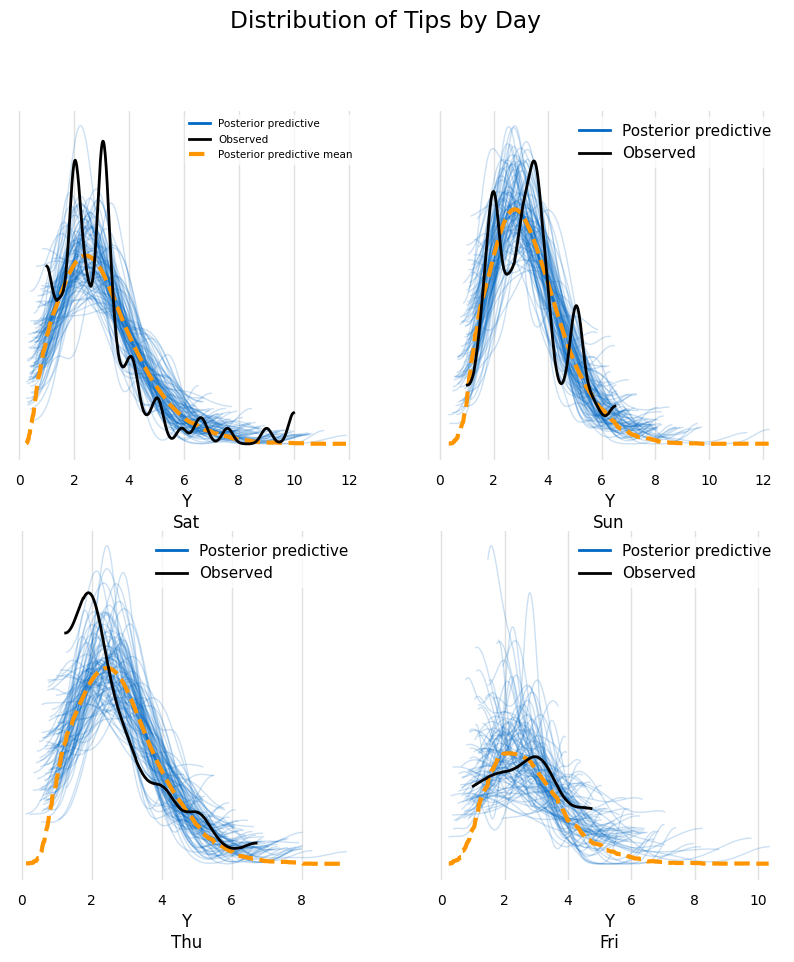

In [112]:
_, ax = pyplot.subplots(2, 2, figsize=(10, 10))
arviz.plot_ppc(idata, num_pp_samples=100, coords={'Obs':days}, flatten=[], ax=ax)
_ = pyplot.suptitle('Distribution of Tips by Day')

KeyError: 'Coords should follow mapping format {coord_name:[dim1, dim2]}. Check that coords structure is correct and dimensions are valid. "\'Obs\' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({\'chain\': 4, \'draw\': 1000, \'μ_dim_0\': 4, \'σ_dim_0\': 4})"'

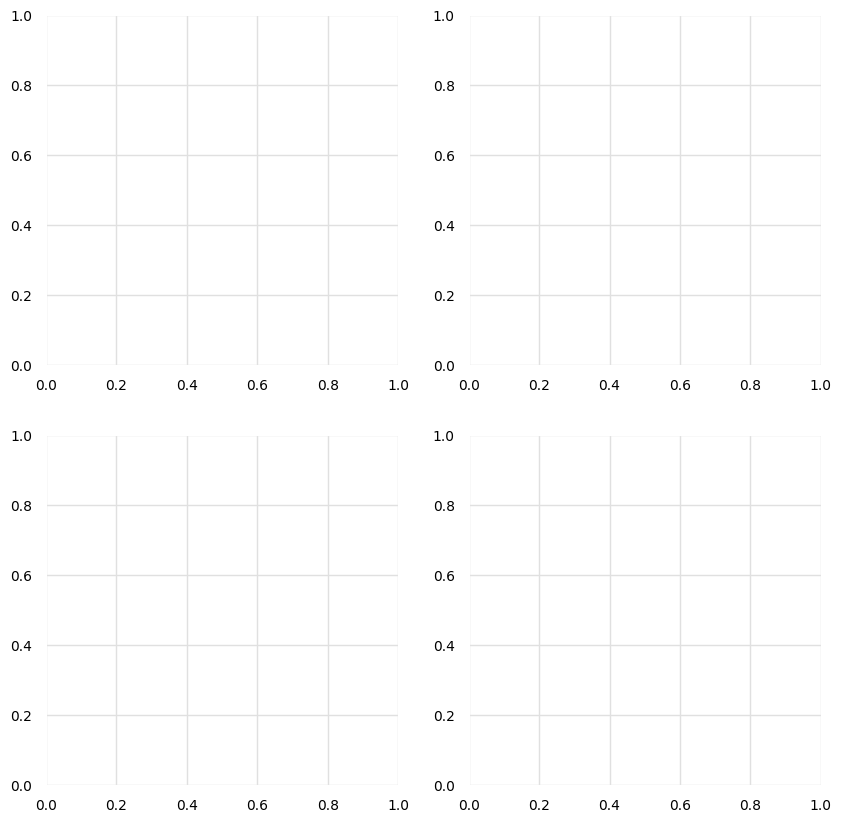

In [121]:
_, ax = pyplot.subplots(2, 2, figsize=(10, 10))
arviz.plot_posterior(idata, coords={'Obs':days}, flatten=[], ax=ax)
_ = pyplot.suptitle('Distribution of Tips by Day')

## Accessing Data

In [113]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [118]:
idata.posterior.data_vars

Data variables:
    μ        (chain, draw, μ_dim_0) float64 128kB 2.664 2.804 ... 2.886 3.513
    σ        (chain, draw, σ_dim_0) float64 128kB 1.131 0.9989 ... 1.397 1.335

In [ ]:
idata.posterior['μ'].to_dataframe()

μ
chain draw μ_dim_0          
0     0    0        2.664408
           1        2.803627
           2        2.749837
           3        3.304694
      1    0        2.620531
...                      ...
3     998  3        3.403239
      999  0        2.862470
           1        2.316882
           2        2.886164
           3        3.512692

[16000 rows x 1 columns]

In [119]:
idata.posterior_predictive.data_vars

Data variables:
    Y        (chain, draw, Obs) float64 8MB 2.681 4.211 2.689 ... 3.476 4.3

In [120]:
idata.posterior_predictive['Y'].to_dataframe()

Y
chain draw Obs          
0     0    Sat  2.681063
           Sun  4.210545
           Sun  2.688636
           Sun  2.711774
           Sun  1.426453
...                  ...
3     999  Sat  2.710597
           Sat  3.704171
           Sat  4.534408
           Sat  3.476355
           Thu  4.300500

[976000 rows x 1 columns]

## Comparing Groups of Data

### Cohen's d

Cohen's d is used to compare two data and is a measure *effect size* of sets and is defined by,

$
\begin{align}
d = \frac{\mu_2 - \mu_1}{\sqrt{\frac{1}{2}\left(\sigma_1^2 + \sigma_2^2\right)}}
\end{align}
\tag{4}
$

This can ne interpreted as Z-Score which measures the number of standard deviations that a value differs from the mean value.

### Probability of Superiority

The probability of superiority is defined as the probability that a data point taken at random from one group has a larger value than one lao taken at random from another group. To understand the probability of superiority consider two independent normal random variables,

$
\begin{align}
X \sim& \mathcal{N}(\mu_X, \sigma_X) \\
Y \sim& \mathcal{N}(\mu_y, \sigma_Y) \\
\end{align}
\tag{5}
$

The goal is to compute,

$
\begin{align}
P(X > Y) = P(Z > 0)
\end{align}
\tag{6}
$

where $Z = X - Y$, Now $Z\sim \mathcal{N}(\mu_Z, \sigma_Z)$ and,

$
\begin{align}
\mu_Z =& \mu_X - \mu_Y \\
\sigma_Z^2 =& \sigma_X^2 + \sigma_Y^2 \\
\end{align}
\tag{7}
$

It follows that $Z \sim \mathcal{N}(\mu_X - \mu_Y, \sigma_X^2 + \sigma_Y^2)$. Now let,

$
\begin{align}
Z^* = \frac{Z - \mu_z}{\sigma_z}
\end{align}
\tag{8}
$

so that $Z^* \sim \mathcal{N}(0, 1)$. Further,

$
\begin{align}
P(Z > 0) = P\left(Z^* > -\frac{\mu_z}{\sigma_z}\right)
\end{align}
\tag{8}
$

Combining Cohen's d from equation $(5)$ and $\mu_Z$ and $\sigma_Z$ from equation $(7)$,

$
\begin{align}
d &= \frac{\mu_2 - \mu_1}{\sqrt{\frac{1}{2}\left(\sigma_1^2 + \sigma_2^2\right)}} \\
d &= \frac{\mu_Z}{\sqrt{\frac{1}{2}\sigma^2_Z}} \\
\frac{d}{\sqrt{2}} &= \frac{\mu_Z}{\sigma_Z}
\end{align}
\tag{10}
$

Using equation $(8)$ gives the desired result,

$
\begin{align}
P(Z > 0) &= P\left(Z^* > -\frac{\mu_z}{\sigma_z}\right) \\
         &= P\left(Z^* > -\frac{d}{\sqrt{2}}\right) \\
         &= 1 - \Phi\left(-\frac{d}{\sqrt{2}}\right) \\
         &= \Phi\left(\frac{d}{\sqrt{2}}\right)
\end{align}
\tag{11}
$





